## Pre-processing and statistical analysis of the theme of the gender of the characters in the movies with the tropes of the movies


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import datetime as dt
import numpy as np
import ast
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats



In [3]:
# open the files
movie_df = pd.read_csv('./data/movie_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip')
char_df=pd.read_csv('./data/character_metadata.csv', sep=',', encoding='utf-8', on_bad_lines='skip')

In [4]:
movie_df.sample(1)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Languages,Countries,Genres
75720,14935193,/m/03h288q,The Jack of Hearts,1919-09-13,NaN,20.0,"{'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...",{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...","['Silent film', 'English Language']",['United States of America'],"['Short Film', 'Silent film', 'Western', 'Blac..."


In [5]:
char_df.sample(1)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
13947,22643200,/m/05zrv0b,1917-05-18,NaN,NaN,M,NaN,NaN,Eugène Beeckman,NaN,/m/0n1s3q9,NaN,/m/0kg5prk


In [6]:
#open the file tvtropes.cluster.txt

# Specify the file path
file_path = './data/tvtropes.clusters.txt'

#Initiatlize lists to store data
tropes=[]
character = []
movie =[]
id=[]
actor=[]

# Open the file in read mode
with open(file_path, 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Split the line into two parts based on the tab character
        parts = line.strip().split('\t')
        
        # The first part is the string, and the second part is the JSON object
        string_part = parts[0]
        json_part = parts[1]

        # Load the JSON object
        try:
            json_object=json.loads(json_part)

            # access specific field in the JSPN object if needed
            character.append(json_object['char'])
            movie.append(json_object['movie'])
            id.append(json_object['id'])
            actor.append(json_object['actor'])

        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)

        # Append data to lists
        tropes.append(string_part)

# Create a DataFrame
data = {'Tropes': tropes, 'Character': character, 'Movie': movie, 'character/actor map ID': id, 'Actor': actor}
tvtropes = pd.DataFrame(data)
        

In [7]:
tvtropes.nunique()

Tropes                     72
Character                 434
Movie                     383
character/actor map ID    447
Actor                     350
dtype: int64

## Data scale visualisation

In [8]:
# Check for unique values in dataframes
print('Character Dataframe')
print(char_df.nunique())
print('Movie Dataframe'), print(movie_df.nunique())
print('Tvtropes Dataframe'), print(tvtropes.nunique())

Character Dataframe
Wikipedia movie ID                  64330
Freebase movie ID                   64330
Movie release date                  18476
Character name                     126629
Actor date of birth                 29494
Actor gender                            2
Actor height                          221
Actor ethnicity                       479
Actor name                         134078
Actor age at movie release            155
Freebase character/actor map ID    450669
Freebase character ID              183435
Freebase actor ID                  135760
dtype: int64
Movie Dataframe
Wikipedia movie ID          81741
Freebase movie ID           81741
Movie name                  75478
Movie release date          20389
Movie box office revenue     7362
Movie runtime                 597
Movie languages              1817
Movie countries              2124
Movie genres                23817
Languages                    1817
Countries                    2124
Genres                      238

(None, None)

Nb of movies in movie df > char df > tv tropes

# Character analysis

In [9]:
#shape of char_df
print('Character Dataframe shape', char_df.shape)

Character Dataframe shape (450669, 13)


In [10]:
# Checking null values in character dataframe
print('Character Dataframe')
print(char_df.isnull().sum())

Character Dataframe
Wikipedia movie ID                      0
Freebase movie ID                       0
Movie release date                   9995
Character name                     257875
Actor date of birth                106145
Actor gender                        45609
Actor height                       295845
Actor ethnicity                    344611
Actor name                           1228
Actor age at movie release         158113
Freebase character/actor map ID         0
Freebase character ID              257865
Freebase actor ID                     815
dtype: int64


In [11]:
# Drop null values in gender column
char_df.dropna(subset=['Actor gender'], inplace=True)

In [12]:
print(char_df.isnull().sum())

Wikipedia movie ID                      0
Freebase movie ID                       0
Movie release date                   9846
Character name                     219599
Actor date of birth                 62635
Actor gender                            0
Actor height                       250397
Actor ethnicity                    299049
Actor name                             12
Actor age at movie release         114290
Freebase character/actor map ID         0
Freebase character ID              219591
Freebase actor ID                       0
dtype: int64


In [13]:
# Drop bi-gender association for each actor ID in character
bi_gender=char_df.groupby('Freebase actor ID')['Actor gender'].transform('nunique')>1
char_df= char_df[~bi_gender]


## Analysis of gender distribution over whole movies

In [14]:
#Drop null values for gender columns, drop duplicates in movie ID column 
gender_movie=char_df[['Freebase movie ID','Actor gender']].dropna().drop_duplicates(subset='Freebase movie ID')
print('Unique values')
print(gender_movie.nunique())
print('Null values')
print(gender_movie.isnull().sum())

Unique values
Freebase movie ID    63652
Actor gender             2
dtype: int64
Null values
Freebase movie ID    0
Actor gender         0
dtype: int64


<AxesSubplot:title={'center':'Actor gender distribution over movie dataset'}>

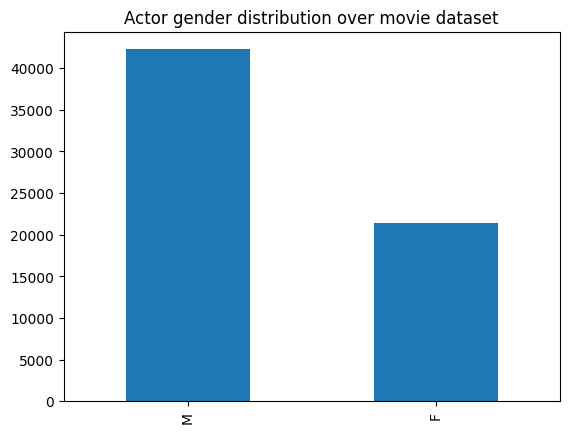

In [15]:
# Print distribution of gender repartition over movies
gender_movie["Actor gender"].value_counts().plot(kind='bar', title='Actor gender distribution over movie dataset')

Male actors play more than women, is it because there is more male actors or because male actors play in more movies than women?
SOLUTION: Observe distribution of gender over actor sample

## Analysis of gender distribution over actors

In [16]:
# Drop null values for gender and actor columns, drop duplicates in actor ID column
gender_actor=char_df[['Freebase actor ID','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
print('Unique values') 
print(gender_actor.nunique())
print('Null values')
print(gender_actor.isnull().sum())

Unique values
Freebase actor ID    97383
Actor gender             2
dtype: int64
Null values
Freebase actor ID    0
Actor gender         0
dtype: int64


<AxesSubplot:title={'center':'Gender distribution over actor set'}>

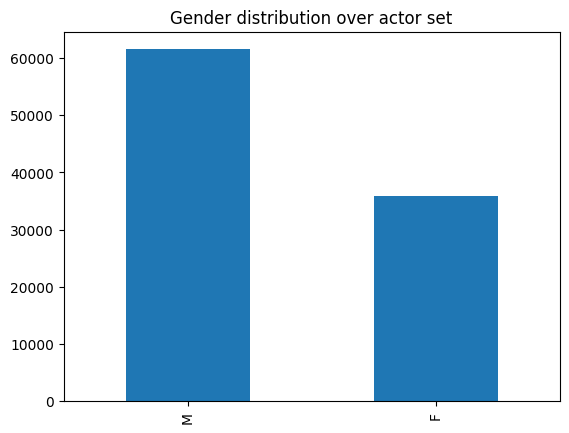

In [17]:
# Print actor gender distribution over actor set
gender_actor["Actor gender"].value_counts().plot(kind='bar', title ='Gender distribution over actor set')

There is more male than female actor in the sample, all observation is going to be influence by this uneven population
Solutions: matching, randomizing samples, 

## Analysis of gender distribution over characters

In [18]:
# Drop null values for gender and character column
# Drop duplicates in character/actor map ID, avoid several interpretations for same character by the same actor
gender_char=char_df[['Character name', 'Actor gender','Freebase character/actor map ID']].dropna().drop_duplicates(subset='Freebase character/actor map ID')
print('Unique values') 
print(gender_char.nunique())
print('Null values')
print(gender_char.isnull().sum())

Unique values
Character name                     122445
Actor gender                            2
Freebase character/actor map ID    185461
dtype: int64
Null values
Character name                     0
Actor gender                       0
Freebase character/actor map ID    0
dtype: int64


<AxesSubplot:title={'center':'Actor gender distribution over characters'}>

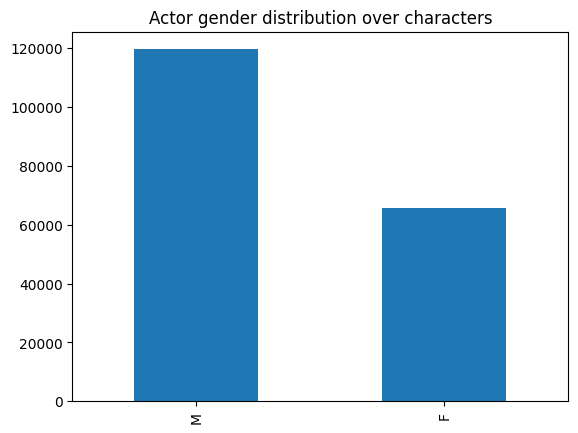

In [19]:
# Print distribution of gender repartition over characters
gender_char["Actor gender"].value_counts().plot(kind='bar', title='Actor gender distribution over characters')

Counted several time same actor 

## Analysis of gender over actor age at movie release

In [20]:
#Drop null values for the age column, drop duplicates in actor ID column
gender_age=char_df[['Freebase actor ID','Actor age at movie release','Actor gender']].dropna().drop_duplicates(subset='Freebase actor ID')
#Drop negative values for age
gender_age['Actor age at movie release']=gender_age['Actor age at movie release'].apply(lambda x: x if x>0 else None).dropna()
print('Unique values')
print(gender_age.nunique())
print('Null values')
print(gender_age.isnull().sum())

Unique values
Freebase actor ID             50956
Actor age at movie release       98
Actor gender                      2
dtype: int64
Null values
Freebase actor ID               0
Actor age at movie release    151
Actor gender                    0
dtype: int64


<AxesSubplot:xlabel='Actor gender', ylabel='Actor age at movie release'>

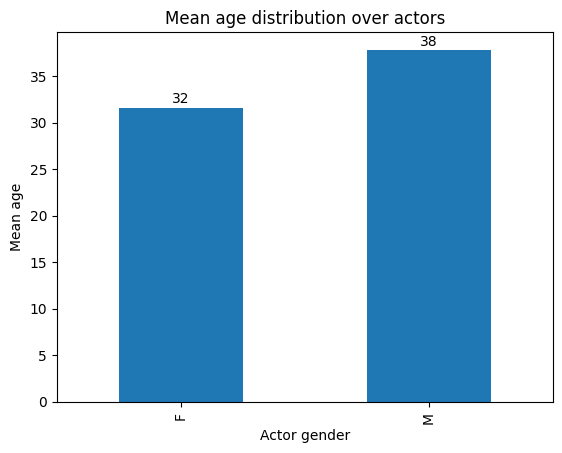

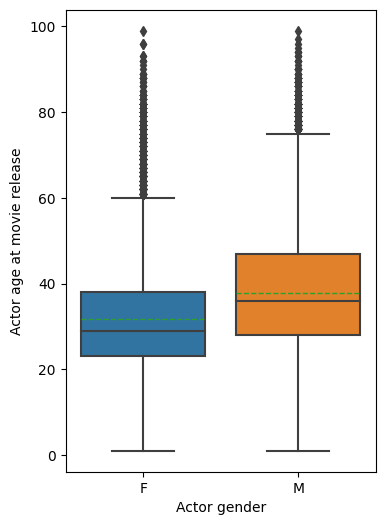

In [21]:
# Print distribution of age repartition over actors
mean_age_df=gender_age.groupby('Actor gender').agg(mean_age=('Actor age at movie release','mean'))
ax= mean_age_df.plot(kind='bar', title='Mean age distribution over actors', legend=False)
plt.ylabel('Mean age')

# Display mean age on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 6), textcoords='offset points')
    
# Print general statistics about age distribution over actors
plt.figure(figsize=(4,6))
sns.boxplot(x='Actor gender', y='Actor age at movie release', data=gender_age, showmeans=True, meanline=True)

In [22]:
gender_age

,Freebase actor ID,Actor age at movie release,Actor gender
0,/m/03wcfv7,42.0,F
1,/m/0346l4,27.0,F
2,/m/01vw26l,32.0,M
3,/m/034hyc,33.0,M
4,/m/01y9xg,23.0,F
...,...,...,...
450623,/m/0gc2b6f,8.0,M
450652,/m/0kr4097,22.0,M
450653,/m/01qwg7h,22.0,F
450660,/m/0gn4bz,38.0,M


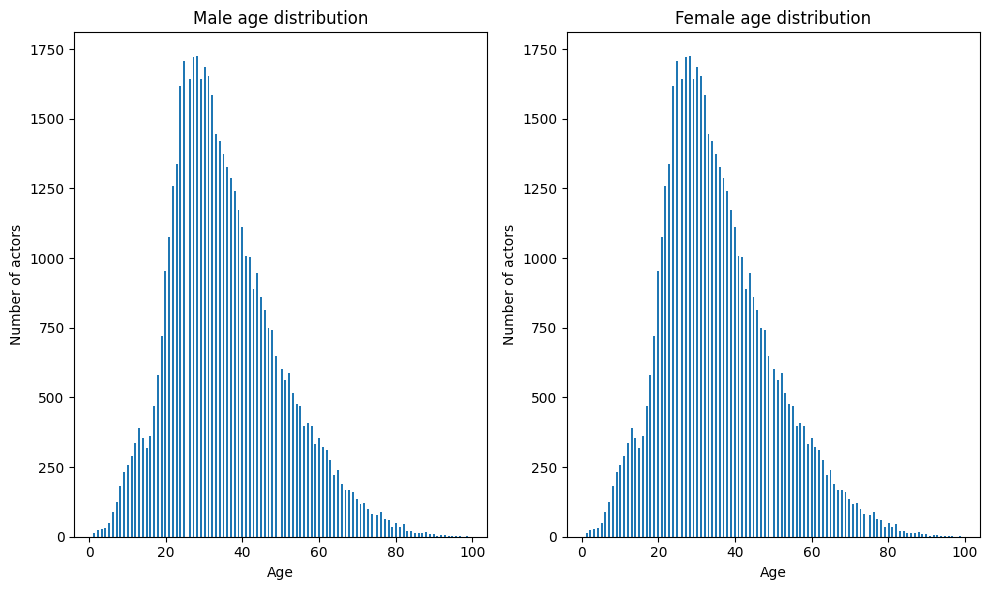

In [23]:
#plot distribution of age of females and males
fig, axs = plt.subplots(1,2, figsize=(10,6))
axs[1].hist(gender_age['Actor age at movie release'], bins=200)
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Number of actors')
axs[1].set_title('Female age distribution')

axs[0].hist(gender_age['Actor age at movie release'], bins=200)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Number of actors')
axs[0].set_title('Male age distribution')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Actor age at movie release', ylabel='Count'>

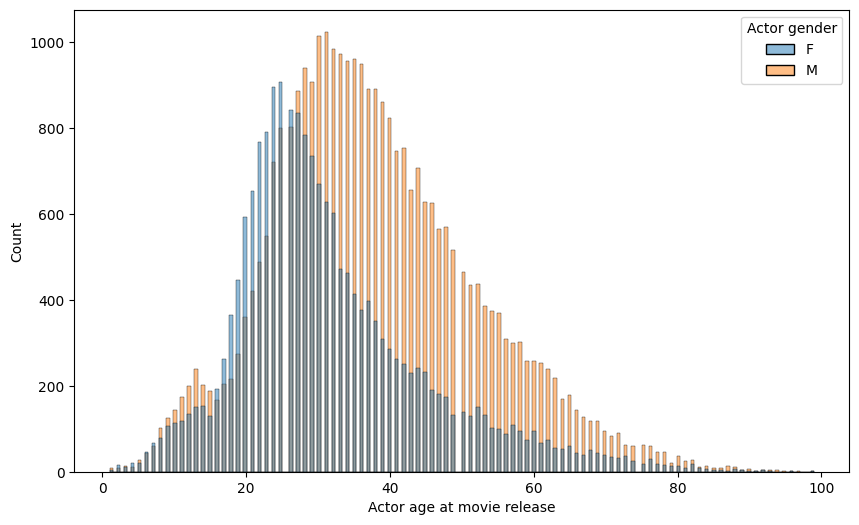

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(x='Actor age at movie release', data=gender_age, hue='Actor gender', bins=200)

## Analysis of gender repartition over year of birth

In [25]:
# Select data and drop null values and duplicates in actors ID column
gender_birth=char_df[['Freebase actor ID', 'Actor gender','Actor date of birth']].dropna().drop_duplicates(subset='Freebase actor ID')
#change date format for the year only
gender_birth['Actor date of birth']=pd.to_datetime(gender_birth['Actor date of birth'], errors='coerce', utc=True)
gender_birth['Actor date of birth']=gender_birth['Actor date of birth'].dt.year.dropna()

# Sanity check
print('Unique values')
print(gender_birth.nunique())
print('Null values')
print(gender_birth.isnull().sum())  
max_birth=max(gender_birth['Actor date of birth'])
print(f'Max birth year: {max_birth}')

Unique values
Freebase actor ID      57461
Actor gender               2
Actor date of birth      178
dtype: int64
Null values
Freebase actor ID       0
Actor gender            0
Actor date of birth    12
dtype: int64
Max birth year: 2050.0


In [26]:
gender_birth.head()

,Freebase actor ID,Actor gender,Actor date of birth
0,/m/03wcfv7,F,1958.0
1,/m/0346l4,F,1974.0
2,/m/01vw26l,M,1969.0
3,/m/034hyc,M,1967.0
4,/m/01y9xg,F,1977.0


<AxesSubplot:xlabel='Actor gender', ylabel='Actor date of birth'>

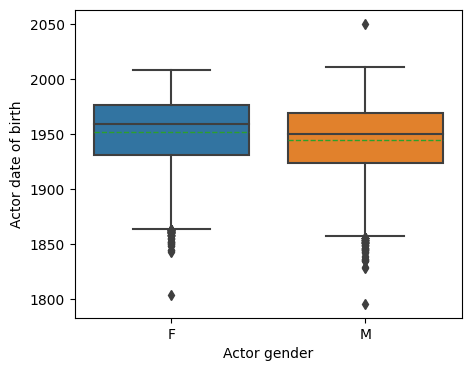

In [27]:
# Print distribution of actors gender over mean birth year with confidence interval
plt.figure(figsize=(5,4))
sns.boxplot(x='Actor gender', y='Actor date of birth', data=gender_birth, showmeans=True, meanline=True)

# Movies analysis

In [28]:
# Select movies with actors we know the genders (common movies between charactere and movie dataframes)

movie_filtered=movie_df[movie_df['Freebase movie ID'].isin(char_df['Freebase movie ID'])]
print('Number of movies :', movie_filtered['Freebase movie ID'].nunique())

Number of movies : 63652


In [29]:
# Associate charactere and movie dataframes on movie ID
char_movie=pd.merge(char_df, movie_filtered, on='Freebase movie ID', how='inner')
char_movie.shape

(405060, 24)

More movies in char_movie because several actors per movies

## Analysis of gender repartition over movies country

In [30]:
# Drop null values
gender_country=char_movie[['Freebase movie ID', 'Actor gender','Freebase actor ID','Countries']].dropna()
# Drop empty dictionnary strings in country column
gender_country=gender_country[gender_country['Countries']!='[]'] 

In [31]:
# Select 16 most common countries
most_common_country=gender_country['Countries'].value_counts()[:16]
# Select movies with most common countries
movies_from_common_countries=gender_country['Countries'].isin(most_common_country.index)
#gender_country[movies_from_common_countries]['Movie countries'].nunique()


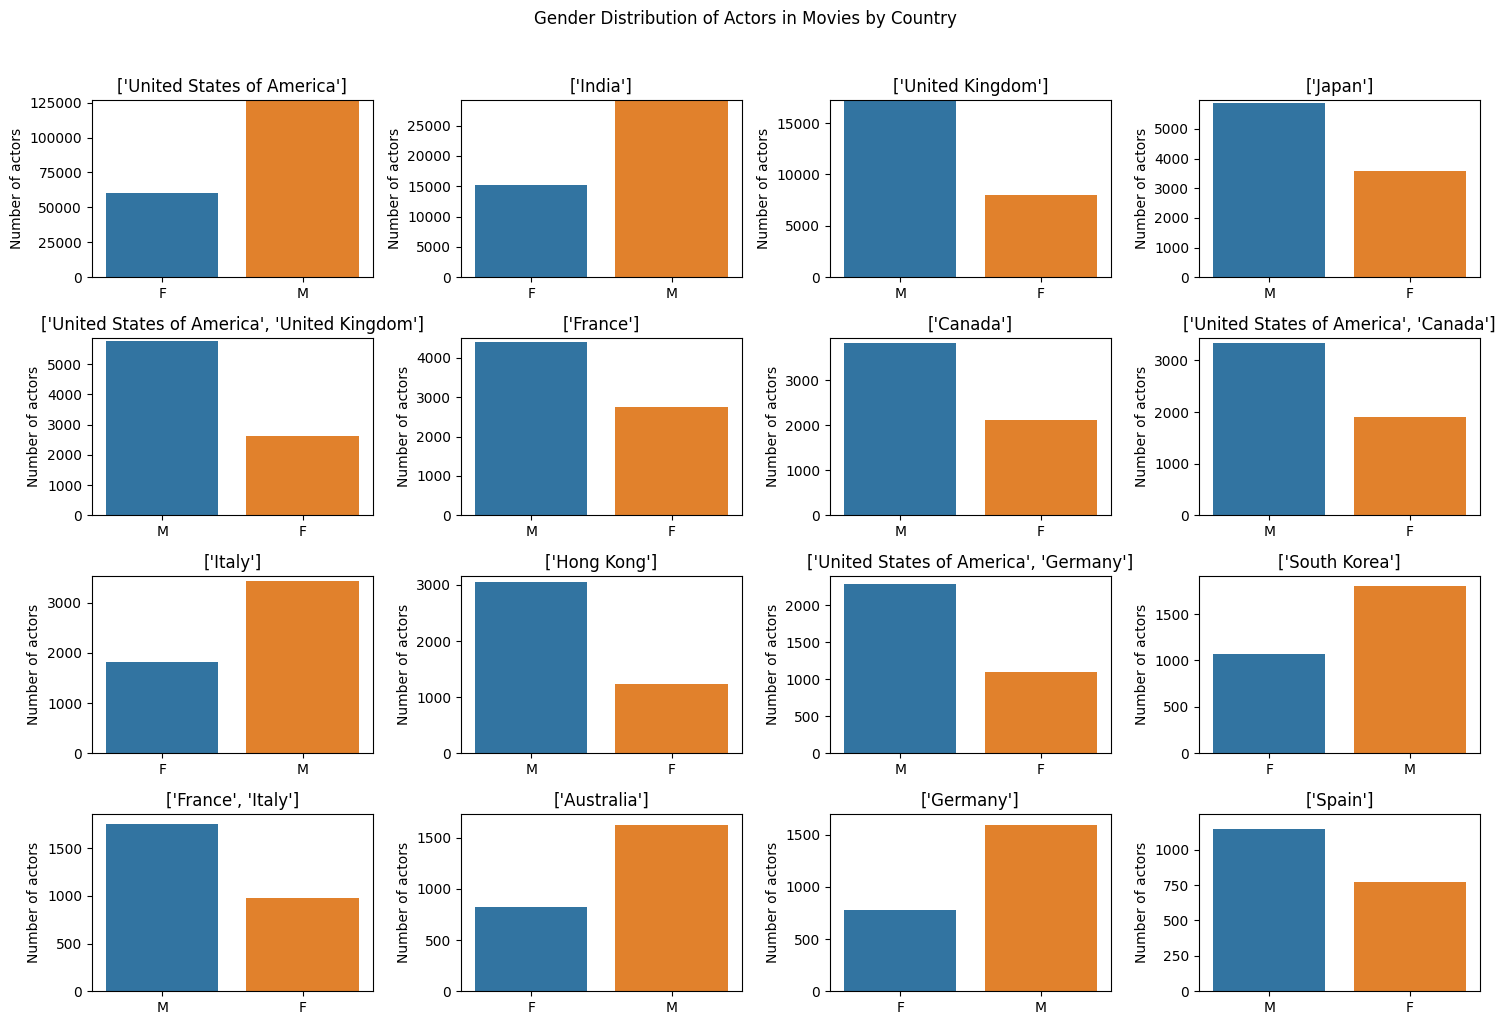

In [32]:
# Print the gender repartition in the movies from the 16 most common countries
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10), sharey=False)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each country and create countplots
for i, country in enumerate(most_common_country.index):
    ax = axes[i]
    country_data = gender_country[gender_country['Countries'] == country]
    sns.countplot(x='Actor gender', data=country_data, ax=ax)
    ax.set_title(country)
    ax.set_xlabel('')  # Clear x-axis label for better aesthetics
    ax.set_ylabel('Number of actors')
    # Set different y-axis scales for each subplot
    ax.set_ylim(0, country_data['Actor gender'].value_counts().max() + 100)


# Set common title for the entire plot
plt.suptitle('Gender Distribution of Actors in Movies by Country', y=1.02)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

To be improved into normalized percentage barplot with countries in x 

In [33]:
gender_country.head(3)

,Freebase movie ID,Actor gender,Freebase actor ID,Countries
0,/m/03vyhn,F,/m/03wcfv7,['United States of America']
1,/m/03vyhn,F,/m/0346l4,['United States of America']
2,/m/03vyhn,M,/m/01vw26l,['United States of America']


In [34]:
# Stack barplot gender per country of movies
gender_country_filtered=gender_country[gender_country['Countries'].isin(most_common_country.index)]
gender_country_filtered.groupby('Countries').apply(list)



Countries
['Australia']                                     [Freebase movie ID, Actor gender, Freebase act...
['Canada']                                        [Freebase movie ID, Actor gender, Freebase act...
['France', 'Italy']                               [Freebase movie ID, Actor gender, Freebase act...
['France']                                        [Freebase movie ID, Actor gender, Freebase act...
['Germany']                                       [Freebase movie ID, Actor gender, Freebase act...
['Hong Kong']                                     [Freebase movie ID, Actor gender, Freebase act...
['India']                                         [Freebase movie ID, Actor gender, Freebase act...
['Italy']                                         [Freebase movie ID, Actor gender, Freebase act...
['Japan']                                         [Freebase movie ID, Actor gender, Freebase act...
['South Korea']                                   [Freebase movie ID, Actor gender, Freeba

## Analysis of gender repartition over the number of characters

In [35]:
char_movie.head()

,Wikipedia movie ID_x,Freebase movie ID,Movie release date_x,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,...,Movie name,Movie release date_y,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."


In [36]:
#find how many actors play in each movie
actor_counts = char_movie.groupby('Freebase movie ID')['Freebase actor ID'].count()
character_counts = char_movie.groupby('Freebase movie ID')['Freebase character ID'].count()
actor_counts.rename('Actor counts', inplace=True)

Freebase movie ID
/m/011_mj     7
/m/011_p6     5
/m/011_zy     4
/m/011wtv    18
/m/011x_4    17
             ..
/m/0yyn5     16
/m/0yyts      7
/m/0yzbg     13
/m/0yzp8     12
/m/0yzvw     10
Name: Actor counts, Length: 63652, dtype: int64

In [37]:
#percentage of females for each sum of characters in each movie
sum_female_char = char_movie.groupby('Freebase movie ID')['Actor gender'].apply(lambda x: (x == 'F').sum())
sum_male_char = char_movie.groupby('Freebase movie ID')['Actor gender'].apply(lambda x: (x == 'M').sum())
perc_female = char_movie.groupby('Freebase movie ID')['Actor gender'].apply(lambda x: (x == 'F').sum()/x.count())
#rename the columen
sum_female_char.rename('Female counts', inplace=True)
sum_male_char.rename('Male counts', inplace=True)
perc_female.head()


Freebase movie ID
/m/011_mj    0.142857
/m/011_p6    0.400000
/m/011_zy    0.250000
/m/011wtv    0.333333
/m/011x_4    0.294118
Name: Actor gender, dtype: float64

In [38]:
fig_df = pd.merge(actor_counts, perc_female, on='Freebase movie ID')
dist_fem_char = pd.merge(actor_counts, sum_female_char, on='Freebase movie ID')
dist_m_char = pd.merge(actor_counts, sum_male_char, on='Freebase movie ID')

In [39]:
fig_df

,Actor counts,Actor gender
Freebase movie ID,,
/m/011_mj,7,0.142857
/m/011_p6,5,0.400000
/m/011_zy,4,0.250000
/m/011wtv,18,0.333333
/m/011x_4,17,0.294118
...,...,...
/m/0yyn5,16,0.437500
/m/0yyts,7,0.571429
/m/0yzbg,13,0.230769


Text(0, 0.5, 'female percentage')

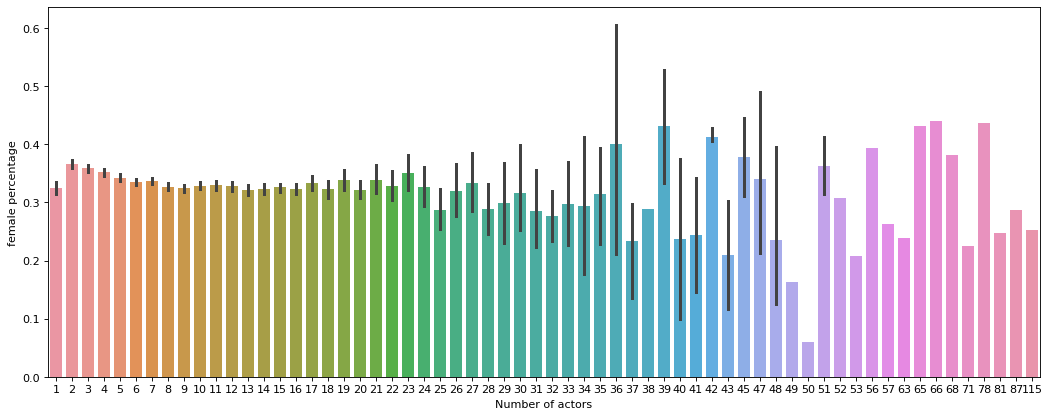

In [77]:
#plot a figure showing the percentage of female actors based on the number of actors in each movie
plt.figure(figsize=(16,6), dpi=80)
ax = sns.barplot(x="Actor counts", y="Actor gender", data=fig_df)
plt.xlabel('Number of actors')
plt.ylabel('female percentage')

As we increase the number of characters, since the samples are small we see an increase in the confidence intervalls suggesting that the data are unreliable.

In [41]:
# Group by the 'actor counts' column and sum the corresponding female and male values
female_char_plot = dist_fem_char.groupby('Actor counts')['Female counts'].sum().reset_index()
male_char_plot = dist_m_char.groupby('Actor counts')['Male counts'].sum().reset_index()

In [42]:
char_plot_df = pd.merge(male_char_plot, female_char_plot, on='Actor counts', how='outer')

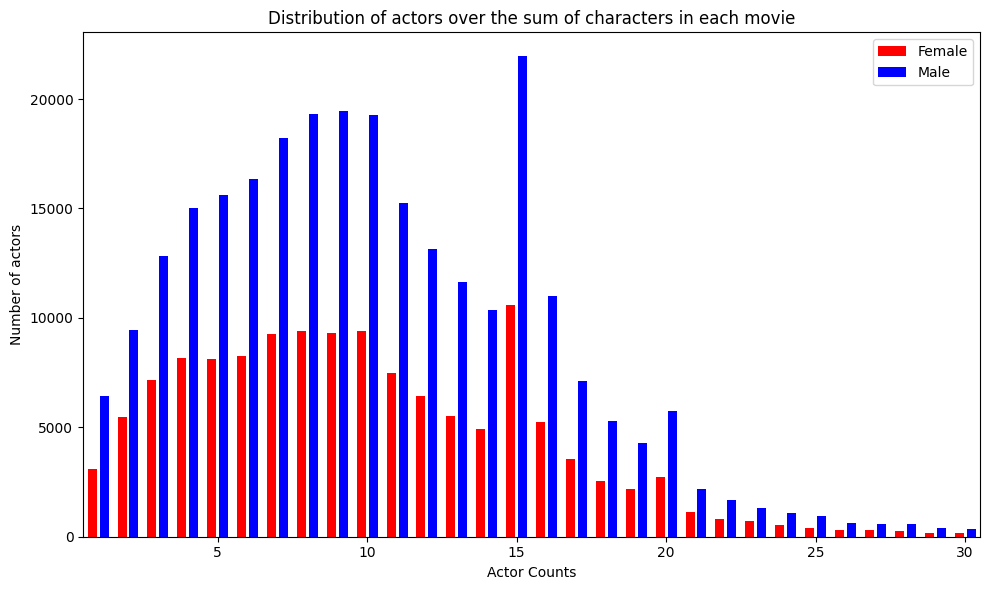

In [43]:
#plot the number of female and male counts over the sum of the characters in each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(char_plot_df['Actor counts']-0.2, char_plot_df['Female counts'],width=0.3, label = 'Female', color='red')
bar2 = ax.bar(char_plot_df['Actor counts']+0.2, char_plot_df['Male counts'],width=0.3, label = 'Male', color='blue')

ax.set_xlabel('Actor Counts')
ax.set_ylabel('Number of actors')
ax.set_title('Distribution of actors over the sum of characters in each movie')
ax.set_xbound(lower=0.5, upper=30.5)
ax.legend()
plt.tight_layout()
plt.show()

We see an increase in actors at around 7-10 characters, however the female actor number stay the same. This suggests that the percentage of females decrease for 6-10 characters in the movie. However, again we see the same trend as we have bigger sample for men than female.

## Analysis of gender repartition over the movie run-time

In [44]:
#copy the merged dataframe to a new smaller dataframe
df_runtime = char_movie[['Freebase movie ID','Freebase actor ID', 'Actor gender','Movie runtime']]

In [45]:
print(df_runtime.shape)
print(df_runtime.isna().sum())

(405060, 4)
Freebase movie ID        0
Freebase actor ID        0
Actor gender             0
Movie runtime        48601
dtype: int64


In [46]:
#remove rows that have null values in the 'Movie runtime' column
df_runtime.dropna(subset=['Movie runtime'], inplace=True)
df_runtime.shape

c:\Users\stavr\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(356459, 4)

In [47]:
df_runtime['Movie runtime'].describe()

count    3.564590e+05
mean     1.325430e+02
std      5.716030e+03
min      0.000000e+00
25%      8.800000e+01
50%      9.800000e+01
75%      1.130000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

In [48]:
#remove 0.1% of the rows with the highest and lowest runtime as they are outliers
df_runtime = df_runtime[df_runtime['Movie runtime'] > df_runtime['Movie runtime'].quantile(0.001)]
df_runtime = df_runtime[df_runtime['Movie runtime'] < df_runtime['Movie runtime'].quantile(0.999)]
df_runtime['Movie runtime'].describe()

count    355486.000000
mean        101.803927
std          29.544800
min           6.100000
25%          88.000000
50%          98.000000
75%         113.000000
max         359.000000
Name: Movie runtime, dtype: float64

In [49]:
#create a df with movie runtimes and the corresponding male and female counts for that runtime
runtime_gender = df_runtime.groupby('Movie runtime').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum())).reset_index()
runtime_gender.head()

,Movie runtime,Female_counts,Male_counts
0,6.10,0,3
1,6.15,1,0
2,6.17,0,9
3,6.18,1,1
4,6.28,2,2


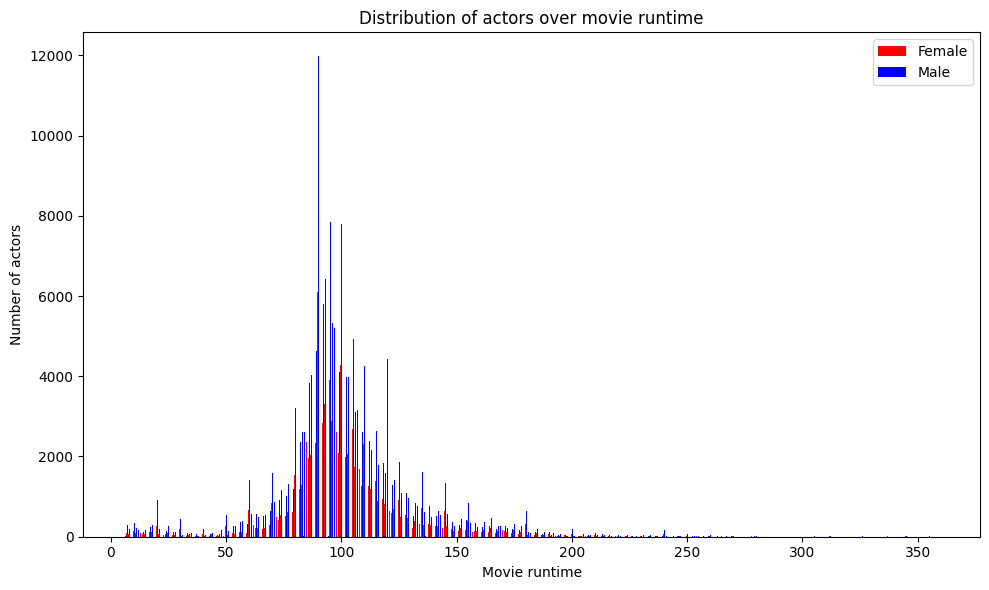

In [50]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(runtime_gender['Movie runtime']-0.2, runtime_gender['Female_counts'],width=0.3, label = 'Female', color='red')
bar2 = ax.bar(runtime_gender['Movie runtime']+0.2, runtime_gender['Male_counts'],width=0.3, label = 'Male', color='blue')

ax.set_xlabel('Movie runtime')
ax.set_ylabel('Number of actors')
ax.set_title('Distribution of actors over movie runtime')
ax.legend()
plt.tight_layout()
plt.show()

Since for the runtimes after 200 we see a really small part of the samples, we plot for a smaller range to see more clearly

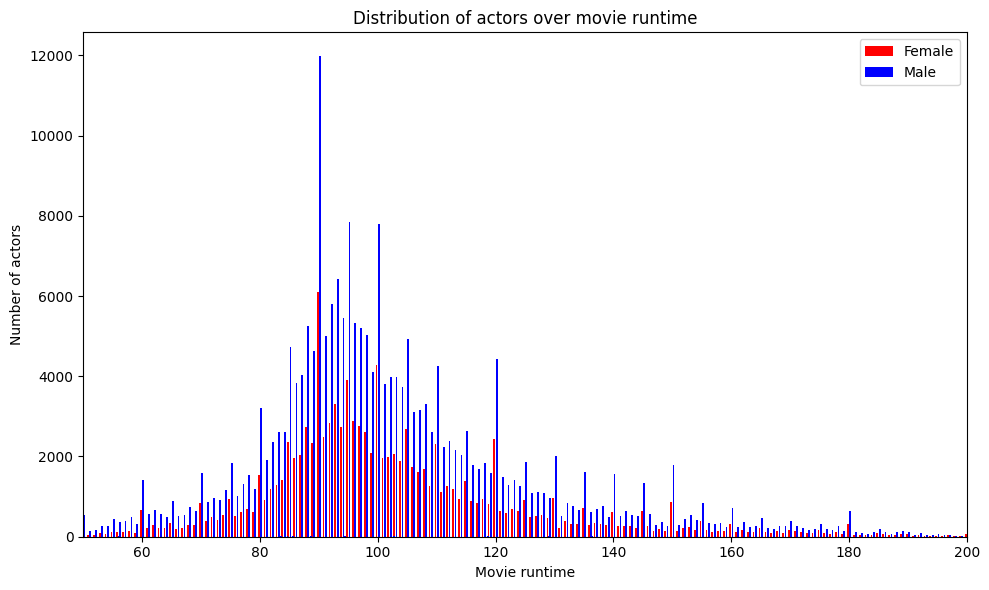

In [51]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(runtime_gender['Movie runtime']-0.2, runtime_gender['Female_counts'],width=0.3, label = 'Female', color='red')
bar2 = ax.bar(runtime_gender['Movie runtime']+0.2, runtime_gender['Male_counts'],width=0.3, label = 'Male', color='blue')

ax.set_xlabel('Movie runtime')
ax.set_ylabel('Number of actors')
ax.set_title('Distribution of actors over movie runtime')
ax.set_xbound(lower=50, upper=200)
ax.legend()
plt.tight_layout()
plt.show()

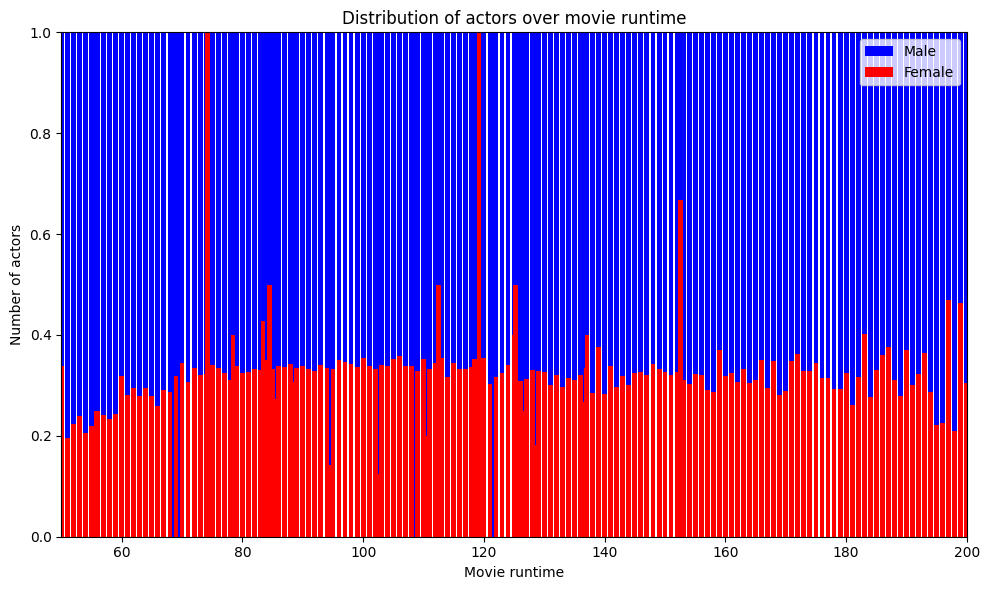

In [52]:
#plot the number of female and male counts over the runtime of each movie
fig, ax = plt.subplots(figsize=(10,6), sharey=True)
bar1 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Male_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']), 
              label = 'Male', color='blue', bottom = runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))
bar2 = ax.bar(runtime_gender['Movie runtime'], runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']) 
              , label = 'Female', color='red',)

ax.set_xlabel('Movie runtime')
ax.set_ylabel('Number of actors')
ax.set_title('Distribution of actors over movie runtime')
ax.set_xbound(lower=50, upper=200)
ax.legend()
plt.tight_layout()
plt.show()

We see the same distribution between male and female actors for different movie runtimes, with females being around half or less than the males as our dataset have generally more males than females

In [85]:
#Using a pearson correlation to show that they are not correlated
stats.pearsonr(runtime_gender['Movie runtime'],runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))

(-0.013425078010734736, 0.7998870884279242)

In [87]:
stats.spearmanr(runtime_gender['Movie runtime'],runtime_gender['Female_counts']/(runtime_gender['Male_counts']+runtime_gender['Female_counts']))

SpearmanrResult(correlation=-0.019000269286903192, pvalue=0.7197592290163861)

The pearson and spearman correlation shows again that there is no significant correlation between runtime and the proportion of female actors in the movie

## Analysis of gender repartition over the years

In [53]:
char_movie.head()

,Wikipedia movie ID_x,Freebase movie ID,Movie release date_x,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,...,Movie name,Movie release date_y,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."


In [54]:
#For each genre create a new subplot
df_year = char_movie.copy()
#change date format for the year only
df_year['Movie release date_x']=pd.to_datetime(df_year['Movie release date_x'], errors='coerce', utc=True)
df_year['Movie release date_x']=df_year['Movie release date_x'].dt.year.dropna().astype(int)
#df_year['Movie year release']=df_year['Movie release date_x'].dt.year.astype(int)
df_gender_year = df_year.groupby('Movie release date_x').agg(Female_counts = ('Actor gender', lambda x: (x == 'F').sum()),
                                                         Male_counts = ('Actor gender', lambda x: (x == 'M').sum()),
                                                         Female_perc = ('Actor gender', lambda x: (x == 'F').sum()/x.count()),
                                                         Male_perc = ('Actor gender', lambda x: (x == 'M').sum()/x.count()),
                                                         Female_means = ('Actor gender', lambda x: (x == 'F').mean()),
                                                         Male_means = ('Actor gender', lambda x: (x == 'M').mean()),
                                                         Female_std = ('Actor gender', lambda x: (x == 'F').std()),
                                                         Male_std = ('Actor gender', lambda x: (x == 'M').std())).reset_index()
df_gender_year.head()

,Movie release date_x,Female_counts,Male_counts,Female_perc,Male_perc,Female_means,Male_means,Female_std,Male_std
0,1888.0,2,2,0.50,0.50,0.50,0.50,0.57735,0.57735
1,1891.0,0,1,0.00,1.00,0.00,1.00,NaN,NaN
2,1893.0,0,2,0.00,1.00,0.00,1.00,0.00000,0.00000
3,1894.0,1,3,0.25,0.75,0.25,0.75,0.50000,0.50000
4,1895.0,0,1,0.00,1.00,0.00,1.00,NaN,NaN


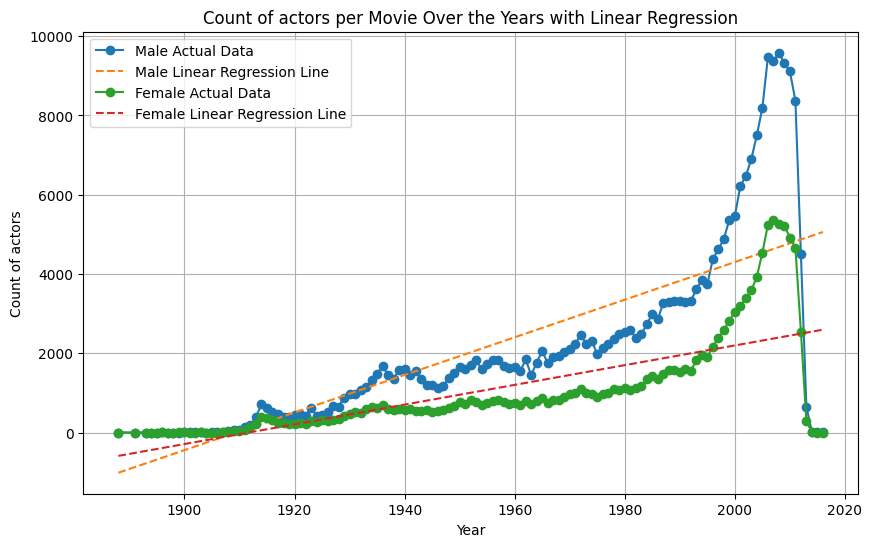

Linear Regression Coefficients for males:
Slope (Coefficient): 47.43
Intercept: -90564.71
R-squared (R²): 0.57
Linear Regression Coefficients for females:
Slope (Coefficient): 24.87
Intercept: -47539.66
R-squared (R²): 0.52
More statistics for males:
F-statistic: 162.4089723434506
p-value: 2.7159541652006476e-24
More statistics for females:
F-statistic: 134.71257074066284
p-value: 1.5502371970061447e-21


In [55]:
years = df_gender_year['Movie release date_x'].values.reshape(-1,1)
male_count_year_r = df_gender_year['Male_counts'].values
female_count_year_r = df_gender_year['Female_counts'].values

#linear regression for the count of actors for each year
regression = LinearRegression()
regression.fit(years, male_count_year_r)

regression_f = LinearRegression()
regression_f.fit(years, female_count_year_r)

# Make predictions using the linear model
predicted_character_counts = regression.predict(years)
predicted_character_counts_f = regression_f.predict(years)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(years, male_count_year_r, marker='o', linestyle='-', label='Male Actual Data')
plt.plot(years, predicted_character_counts, linestyle='--', label='Male Linear Regression Line')

plt.plot(years, female_count_year_r, marker='o', linestyle='-', label='Female Actual Data')
plt.plot(years, predicted_character_counts_f, linestyle='--', label='Female Linear Regression Line')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Count of actors')
plt.title('Count of actors per Movie Over the Years with Linear Regression')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

r_squared = r2_score(male_count_year_r, predicted_character_counts)
r_squared_f = r2_score(female_count_year_r, predicted_character_counts_f)

# Print the linear regression coefficients
print("Linear Regression Coefficients for males:")
print(f"Slope (Coefficient): {regression.coef_[0]:.2f}")
print(f"Intercept: {regression.intercept_:.2f}")
# Print the R-squared value
print(f"R-squared (R²): {r_squared:.2f}")

# Print the linear regression coefficients
print("Linear Regression Coefficients for females:")
print(f"Slope (Coefficient): {regression_f.coef_[0]:.2f}")
print(f"Intercept: {regression_f.intercept_:.2f}")
# Print the R-squared value
print(f"R-squared (R²): {r_squared_f:.2f}")


X_male = sm.add_constant(years)
X_female = sm.add_constant(years)  # Add a constant term for the intercept
model_male = sm.OLS(male_count_year_r, X_male).fit()
model_female = sm.OLS(female_count_year_r, X_female).fit()

print("More statistics for males:")
print("F-statistic:", model_male.fvalue)
print("p-value:", model_male.f_pvalue)

print("More statistics for females:")
print("F-statistic:", model_female.fvalue)
print("p-value:", model_female.f_pvalue)

Ok linear regression does not really make sense hear as we obviously see an exponential increase in the recent years

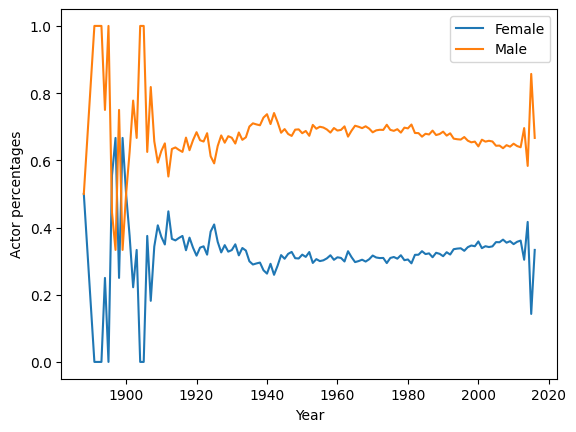

In [56]:
#plotting the percentages of male and females actors over the years
# Calculate yearly stats across movies here
plt.plot(df_gender_year['Movie release date_x'], df_gender_year['Female_means'],
             label = 'Female')
plt.plot(df_gender_year['Movie release date_x'], df_gender_year['Male_means'],
             label = 'Male')
plt.xlabel('Year')
plt.ylabel('Actor percentages')
plt.legend()
plt.show()


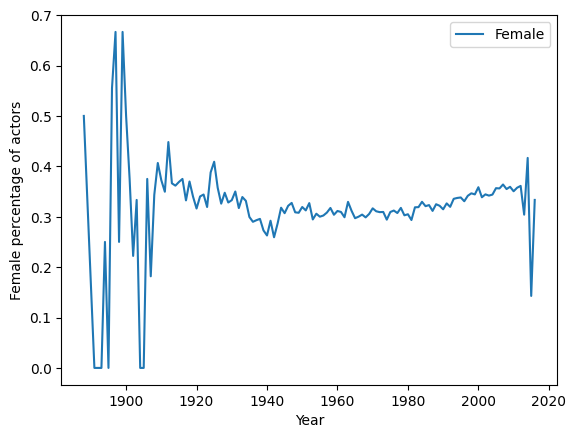

In [57]:
#plotting the percentages of female actors over the years
# Calculate yearly stats across movies here
plt.plot(df_gender_year['Movie release date_x'], df_gender_year['Female_means'],
             label = 'Female')
plt.xlabel('Year')
plt.ylabel('Female percentage of actors')
plt.legend()
plt.show()

In [58]:
df_gender_year_old = df_gender_year[df_gender_year['Movie release date_x'] <= 1915]
df_gender_year_new = df_gender_year[df_gender_year['Movie release date_x'] > 1915]
female_counts_1915 = df_gender_year_old['Female_counts'].sum()
female_counts_new = df_gender_year_new['Female_counts'].sum()
print('Percentage of female actors for movies made before 1915', female_counts_1915/female_counts_new*100,'%')

Percentage of female actors for movies made before 1915 1.0395826279663887 %


In [90]:
df_gender_year_last = df_gender_year[df_gender_year['Movie release date_x'] > 2012]
df_gender_year_med = df_gender_year[df_gender_year['Movie release date_x'] <= 2012]
female_counts_last = df_gender_year_last['Female_counts'].sum()
female_counts_med= df_gender_year_med['Female_counts'].sum()
print('Percentage of female actors for movies made after 2012', female_counts_last/female_counts_med*100,'%')

Percentage of female actors for movies made after 2012 0.22899539719251644 %


Since just 1% of the female actors are before 1915 we can remove them as the percentage is really small

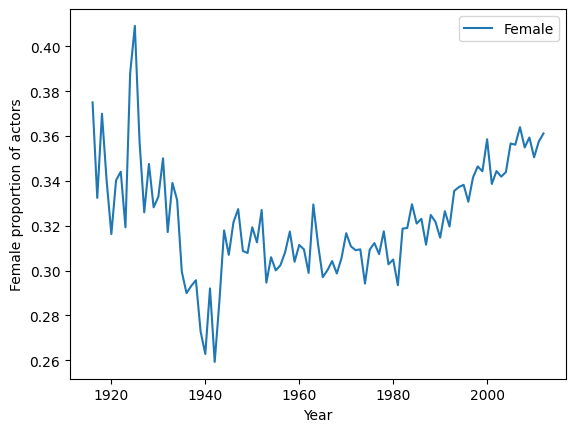

In [92]:
#plotting the percentages of female actors over the years
# Calculate yearly stats across movies here
df_gender_year_mid = df_gender_year[(df_gender_year['Movie release date_x'] <= 2012) & (df_gender_year['Movie release date_x'] > 1915)]
plt.plot(df_gender_year_mid['Movie release date_x'], df_gender_year_mid['Female_perc'],
             label = 'Female')
plt.xlabel('Year')
plt.ylabel('Female proportion of actors')
plt.legend()
plt.show()

So percentage wise the gender repartition it looks to be stable across the years (not considering the first 30 years that are a really small sample) 

## Propensity scores of covariates

We have as covariates the age of the actor, the movie country, movie genre, movie release year, characters and runtime

In [60]:
#get the columns that we need as covariates
df_propensity = char_movie[['Freebase movie ID','Movie release date_x','Genres','Countries','Movie runtime', 'Actor age at movie release','Actor gender']]
df_propensity.head()

,Freebase movie ID,Movie release date_x,Genres,Countries,Movie runtime,Actor age at movie release,Actor gender
0,/m/03vyhn,2001-08-24,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",['United States of America'],98.0,42.0,F
1,/m/03vyhn,2001-08-24,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",['United States of America'],98.0,27.0,F
2,/m/03vyhn,2001-08-24,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",['United States of America'],98.0,32.0,M
3,/m/03vyhn,2001-08-24,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",['United States of America'],98.0,33.0,M
4,/m/03vyhn,2001-08-24,"['Thriller', 'Science Fiction', 'Horror', 'Adv...",['United States of America'],98.0,23.0,F


In [61]:
print(df_propensity.shape)
print(df_propensity.isna().sum())

(405060, 7)
Freebase movie ID                  0
Movie release date_x            9846
Genres                             0
Countries                          0
Movie runtime                  48601
Actor age at movie release    114290
Actor gender                       0
dtype: int64


In [62]:
#drop the null values
df_propensity.dropna(inplace=True)
df_propensity.shape

c:\Users\stavr\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(262639, 7)

In [63]:
#change date format for the year only
df_propensity['Movie release date_x']=pd.to_datetime(df_propensity['Movie release date_x'], errors='coerce', utc=True)
df_propensity['Movie release date_x']=df_propensity['Movie release date_x'].dt.year.dropna().astype(int)

C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
# Function to safely convert string representations of lists into actual lists
def string_to_list(list_string):
    try:
        # This safely evaluates a string as a list
        return ast.literal_eval(list_string)
    except ValueError:
        # In case of error (e.g., empty strings), return an empty list
        return []

In [65]:
df_propensity['Genres'] = df_propensity['Genres'].apply(string_to_list)
df_propensity['Countries'] = df_propensity['Countries'].apply(string_to_list)

df_propensity.head()

C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Freebase movie ID,Movie release date_x,Genres,Countries,Movie runtime,Actor age at movie release,Actor gender
0,/m/03vyhn,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],98.0,42.0,F
1,/m/03vyhn,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],98.0,27.0,F
2,/m/03vyhn,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],98.0,32.0,M
3,/m/03vyhn,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],98.0,33.0,M
4,/m/03vyhn,2001,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],98.0,23.0,F


In [66]:
df_propensity['Genres'] = df_propensity['Genres'].apply(tuple)
df_propensity['Countries'] = df_propensity['Countries'].apply(tuple)

C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stavr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [67]:
df_propensity.head()

,Freebase movie ID,Movie release date_x,Genres,Countries,Movie runtime,Actor age at movie release,Actor gender
0,/m/03vyhn,2001,"(Thriller, Science Fiction, Horror, Adventure,...","(United States of America,)",98.0,42.0,F
1,/m/03vyhn,2001,"(Thriller, Science Fiction, Horror, Adventure,...","(United States of America,)",98.0,27.0,F
2,/m/03vyhn,2001,"(Thriller, Science Fiction, Horror, Adventure,...","(United States of America,)",98.0,32.0,M
3,/m/03vyhn,2001,"(Thriller, Science Fiction, Horror, Adventure,...","(United States of America,)",98.0,33.0,M
4,/m/03vyhn,2001,"(Thriller, Science Fiction, Horror, Adventure,...","(United States of America,)",98.0,23.0,F


In [68]:
df_propensity_exploded = df_propensity.explode('Genres')
df_propensity_exploded = df_propensity_exploded.explode('Countries')
df_propensity_exploded.head()

,Freebase movie ID,Movie release date_x,Genres,Countries,Movie runtime,Actor age at movie release,Actor gender
0,/m/03vyhn,2001,Thriller,United States of America,98.0,42.0,F
0,/m/03vyhn,2001,Science Fiction,United States of America,98.0,42.0,F
0,/m/03vyhn,2001,Horror,United States of America,98.0,42.0,F
0,/m/03vyhn,2001,Adventure,United States of America,98.0,42.0,F
0,/m/03vyhn,2001,Supernatural,United States of America,98.0,42.0,F


In [69]:
df_propensity_exploded.shape

(1499283, 7)

In [70]:
#change the categorical variables to dummy variables
# One-hot encode the genres and countries variable
df_propensity_dummy = pd.get_dummies(df_propensity_exploded, columns=['Countries'], drop_first=True)
df_propensity_dummy = pd.get_dummies(df_propensity_dummy, columns=['Genres'], drop_first=True)
df_propensity_dummy.head()

,Freebase movie ID,Movie release date_x,Movie runtime,Actor age at movie release,Actor gender,Countries_Albania,Countries_Algeria,Countries_Argentina,Countries_Armenia,Countries_Aruba,...,Genres_Werewolf fiction,Genres_Western,Genres_Whodunit,Genres_Women in prison films,Genres_Workplace Comedy,Genres_World History,Genres_World cinema,Genres_Wuxia,Genres_Z movie,Genres_Zombie Film
0,/m/03vyhn,2001,98.0,42.0,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,F,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
#change the Gender column to 0 and 1
df_propensity_dummy['Actor gender'] = df_propensity_dummy['Actor gender'].apply(lambda x: 1 if x=='F' else 0)
df_propensity_dummy.head()

,Freebase movie ID,Movie release date_x,Movie runtime,Actor age at movie release,Actor gender,Countries_Albania,Countries_Algeria,Countries_Argentina,Countries_Armenia,Countries_Aruba,...,Genres_Werewolf fiction,Genres_Western,Genres_Whodunit,Genres_Women in prison films,Genres_Workplace Comedy,Genres_World History,Genres_World cinema,Genres_Wuxia,Genres_Z movie,Genres_Zombie Film
0,/m/03vyhn,2001,98.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,/m/03vyhn,2001,98.0,42.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Get the features in a new dataframe
df_propensity_dummy_features = df_propensity_dummy.drop(['Freebase movie ID','Actor gender'], axis=1)
#Get the target variable in a new dataframe
df_propensity_dummy_target = df_propensity_dummy['Actor gender']

The exploded dataframe is too big to be used on logistic regression. So we will try to do the same but with just using the 10 highest countries and genres in terms of number of actors

In [73]:
# Fit a logistic regression model to estimate propensity scores
model = LogisticRegression()
model.fit(df_propensity_dummy_features, df_propensity_dummy_target)

# Get the predicted propensity scores for the synthetic data
propensity_scores = model.predict_proba(df_propensity_dummy_features)[:, 1]

# Add propensity scores and gender indicator to the data
df_propensity_dummy['propensity_score'] = propensity_scores

# Display the first few rows of the data with propensity scores and gender indicator
print(df_propensity_dummy.head())

  Freebase movie ID  Movie release date_x  Movie runtime  \
0         /m/03vyhn                  2001           98.0   
0         /m/03vyhn                  2001           98.0   
0         /m/03vyhn                  2001           98.0   
0         /m/03vyhn                  2001           98.0   
0         /m/03vyhn                  2001           98.0   

   Actor age at movie release  Actor gender  Countries_Albania  \
0                        42.0             1                  0   
0                        42.0             1                  0   
0                        42.0             1                  0   
0                        42.0             1                  0   
0                        42.0             1                  0   

   Countries_Algeria  Countries_Argentina  Countries_Armenia  Countries_Aruba  \
0                  0                    0                  0                0   
0                  0                    0                  0                0   

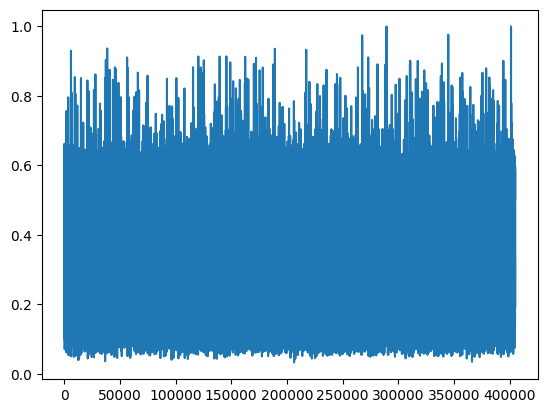

In [74]:
plt.plot(df_propensity_dummy['propensity_score'])

## Analysis of gender repartition based on the month/season

In [78]:
char_movie.head()

,Wikipedia movie ID_x,Freebase movie ID,Movie release date_x,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,...,Movie name,Movie release date_y,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv..."


In [ ]:
char_movie_month = char_movie[['Freebase movie ID','Movie release date_x','Actor gender', '']]